# INTRODUCTION

As Americans, we are constantly reminded of the country's strong gun culture: every day, the news will inevitably contain
some sort of gun-related news story, from a recent devastating mass shooting event to a story about someone open-carrying
in an unexpected place, like a grocery store, to someone's opinion as to why we should abolish the second amendment (or
why it's a good idea to have it!). The American media would make it seem that the United States has a lot more guns than
any other country in the world. Is that true? And, considering our frequent gun violence-related headlines and mass murders,
do we have as many murders as the media would make us believe? How does our murder rate compare to other countries? In this report we will be analyzing data from around the world to see how the United States compares to other nations in our levels of gun-ownership, and test for a relationship between that statistic and the rate of homicides.

Let's get exploring!

Here are all of the packages that we will be using for this analysis

In [2]:
import matplotlib
import requests
import pandas as pd
import tabula.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statistics import mean

# DATA COLLECTION

We have decided to use two sets of data for this project, each involving many countries around the world: gun ownership,
and a collection of homicide rates per 100,000 people

The 2017 gun ownership data originated from smallarmssurvey.org, an organization that maintains databases on small
arms-related statistics worldwide: violent deaths, firearms holdings, etc. We felt that the data, given the organization's
focus on impartial analysis, would be thorough and well-researched.

Next, we located some data on intentional homicides on a website called Indexmundi; it pulled the data from the United Nations
Office on Drugs and Crime. We'd originally attempted to pull all of our data for this directly from the United Nations, but it was difficult to work with due to massive amounts of missing data. For example, the 2017 data for the United States was completely missing--which, incidentally, is the only year with decent gun ownership data that we were able to locate. Similar issues like this were also found with several other countries listed in the table, and others that were not present at all. Therefore, we decided to use the Indexmundi data and filtered out the non-2017 data.

Using these two sets of data, we can keep data regarding intentional homicides and national gun ownership organized in Dataframes in such a way that is easy to access and perform operations and analyses on.

In [4]:
# Opening the gun ownership data and creating a Dataframe from it using tabula
url = "http://www.smallarmssurvey.org/fileadmin/docs/Weapons_and_Markets/Tools/Firearms_holdings/SAS-BP-Civilian-held-firearms-annexe.pdf"
got_gun = tabula.io.read_pdf(url, output_format='dataframe', pages='all')

#rename columns
got_gun[0].columns=['country_code', 'country', 'region', 'subregion', 'population', 'total_est_guns', 'est_of_guns_per_100_ppl', 'delete1', 'comp_method', 'registered_guns', 'delete2', 'unregistered_guns']

#drop some unnecessary columns & rows
got_gun[0].drop(range(0,5), inplace=True)
got_gun[0].drop(columns=['delete1', 'delete2', 'comp_method', 'registered_guns', 'unregistered_guns', 'est_of_guns_per_100_ppl'], inplace=True)

got_gun[0].head()

,country_code,country,region,subregion,population,total_est_guns
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000"
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000"
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000"
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000"


In the above DataFrame, we now have all of our data for gun ownership rates per country around the world. Next, we will gather our data regarding homicide rates around the world for the year 2017 so that the tables' timeframe matches up:

In [6]:
# scraping the intentional homicide data & putting into a dataframe
r = requests.get('https://www.indexmundi.com/facts/indicators/VC.IHR.PSRC.P5/rankings')
homs = pd.read_html(r.text)[0].drop(['Rank'], axis=1)
homs.loc[homs['Year'] == 2017]

,Country,Value,Year
0,El Salvador,61.8,2017
1,Jamaica,57.0,2017
3,Honduras,41.7,2017
5,Belize,37.9,2017
7,South Africa,35.9,2017
...,...,...,...
161,Luxembourg,0.3,2017
162,"Macao SAR, China",0.3,2017
163,"Hong Kong SAR, China",0.3,2017
164,Singapore,0.2,2017


# DATA MANAGEMENT

Now that we have gathered and stored our data, we can move on to organizing it a bit. To start, we will get rid of our rows in our gun ownership DataFrame that is inputted incorrectly. There are some extra rows that were picked up from the web-scraping that do not contain actual data, so we will get rid of them here:

In [8]:
regions = [reg for reg in got_gun[0]['region'].unique() if reg in ['Asia', 'Oceania', 'Europe', 'Africa', 'Americas']]
rows = []
for row in got_gun[0].iterrows():
    if row[1]['region'] in regions and row[1]['total_est_guns'] != '-':
        rows.append(row[1])
gun_owners = pd.DataFrame(rows)
gun_owners.head()

,country_code,country,region,subregion,population,total_est_guns
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000"
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000"
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000"
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000"


Now this is the cleaned up version of the table. The next thing that I want to do is scale the guns-per-people stat up to every 100,000 people instead of every hundred people. This is because the data for homicides around the world is measured as a value per 100,000 people, so it will make things easier to have them match and be a bit more precise.

In [10]:
# adding a column for guns per 100k citizens into dataframe
per_100k = []
for row in gun_owners.iterrows():
    val = (float(row[1]['total_est_guns'].replace(",", "")) / float(row[1]['population'].replace(",", ""))) * 100000
    per_100k.append(round(val, 2))
# Add the new column to the DataFrame
gun_owners['guns_per_100k'] = per_100k
gun_owners.head()

,country_code,country,region,subregion,population,total_est_guns,guns_per_100k
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000",12496.71
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000",12023.36
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000",2135.69
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400,714.29
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000",14492.75


Now we have everything we need, nice and tidy, and are ready to move on to actually visualizing and analyzing the data!

# DATA VISUALIZATION AND ANALYSIS

The very first thing that we will do here is break up our data on gun ownership by region. To do this, we can use a dictionary, defined below as "guns_per_region." This dictionary maps strings, representing the names of the regions, to a smaller DataFrame containing all of the gun ownership data for that region. This will be useful when we plot all of our data per each region.

In [12]:
guns_per_region = {}
for reg in gun_owners['region'].unique():
    # Create a smaller subset of the DataFrame, and store it here for later use
    guns_per_region[reg] = pd.DataFrame(gun_owners.loc[gun_owners['region'] == reg])

Now we can begin setting up our data to plot. First, we are going to plot a scatterplot to look for a relationship between a country's population and its level of gun ownership. To start, I will store all of our data by country code for population and gun ownership rate:

In [14]:
pop = {}
guns = {}
# Each dictionary is sorted by region
for key in guns_per_region.keys():
    table = guns_per_region[key]
    total_pop = {}
    total_gun = {}
    # The dictionaries inside will map the country code to that country's population and total guns, respectively
    for row in table.iterrows():
        total_pop[row[1]['country_code']] = int(row[1]['population'].replace(",", ""))
        total_gun[row[1]['country_code']] = float(row[1]['total_est_guns'].replace(",", ""))
    pop[key] = total_pop
    guns[key] = total_gun

We have now gathered up all of our data for each nation's population and gun ownership, organized into 5 groups by region. Now we can actually plot them using matplotlib and see if there is a clear relationship:

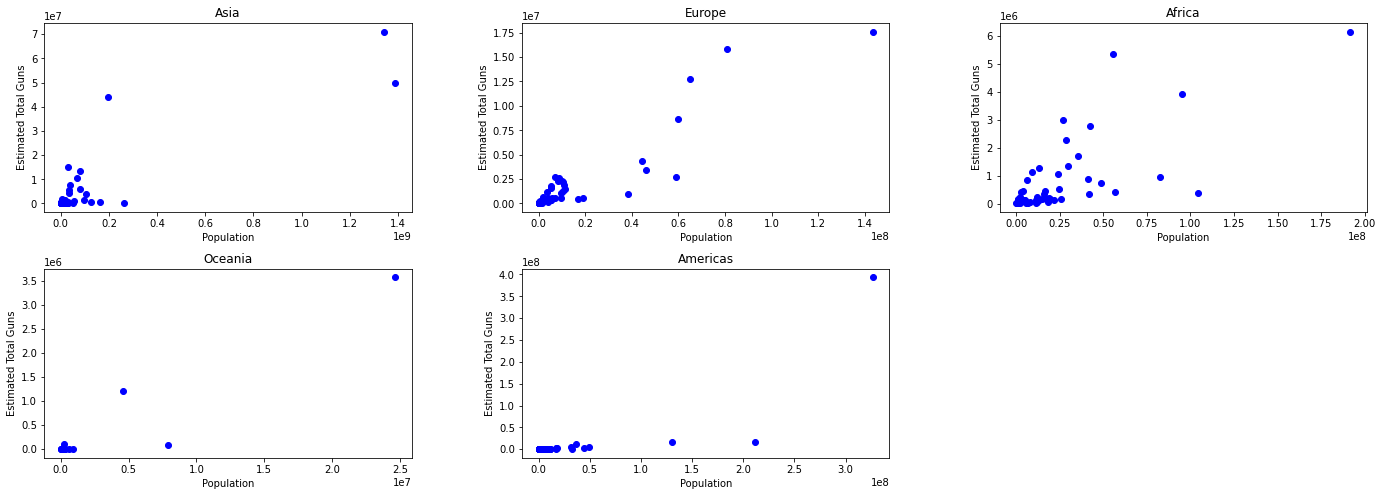

In [16]:
# This section of code creates the plots for total guns against total population
titles = list(guns_per_region.keys())
# Use this loop to generate one plot per region
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(left=0.125, right=1.35, hspace=0.3, wspace=0.3)

count = 1
for i in titles:
    x = (np.array(list(pop[i].values())))
    y = (np.array(list(guns[i].values())))

    ax = fig.add_subplot(2,3,count)
    plt.scatter(x, y, color="Blue")

    plt.xlabel("Population")
    plt.ylabel("Estimated Total Guns")
    plt.title(i)

    count+=1

Looking at these tables, there seems to be a bit of a linear relationship between the two variables, albeit not a perfect one. Additionally, there are clearly a couple of nations on each graph that are well and by far above all of the rest on both axes. Lets use sklearn to plot a linear regression to check for linear relationships, and look at the y-axis value where the graph begins to spike and label these nations to see which ones are the highest on the table:

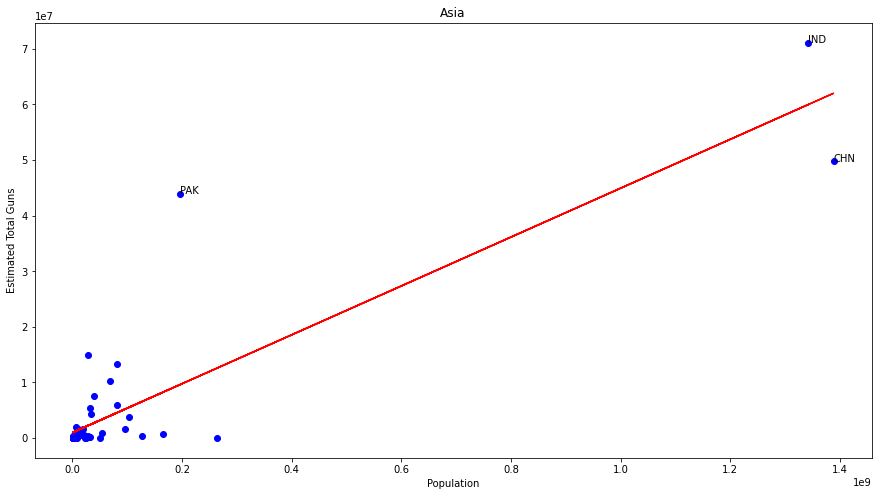

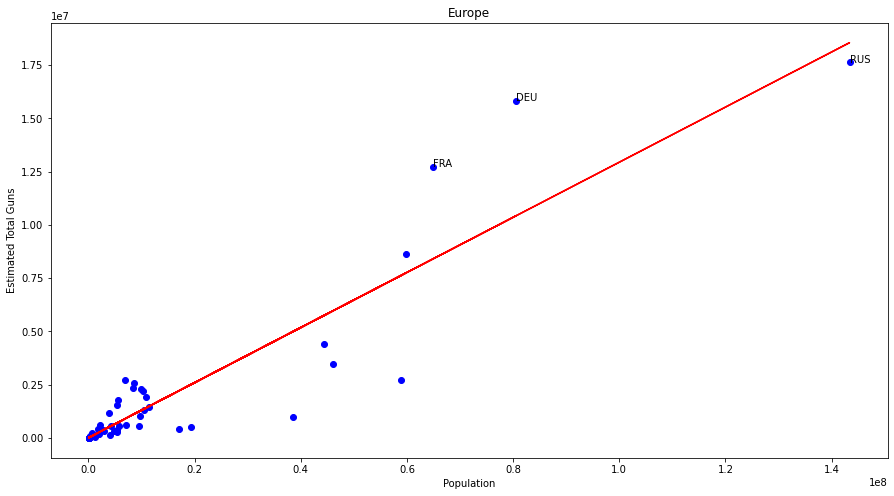

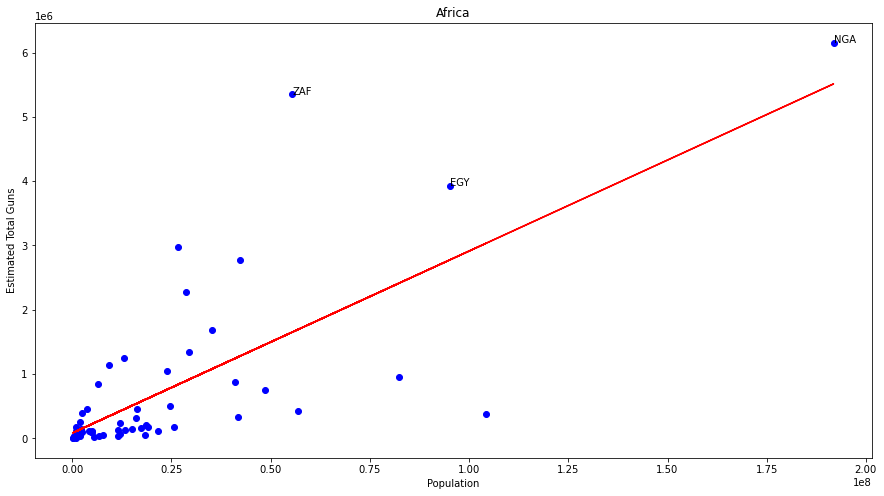

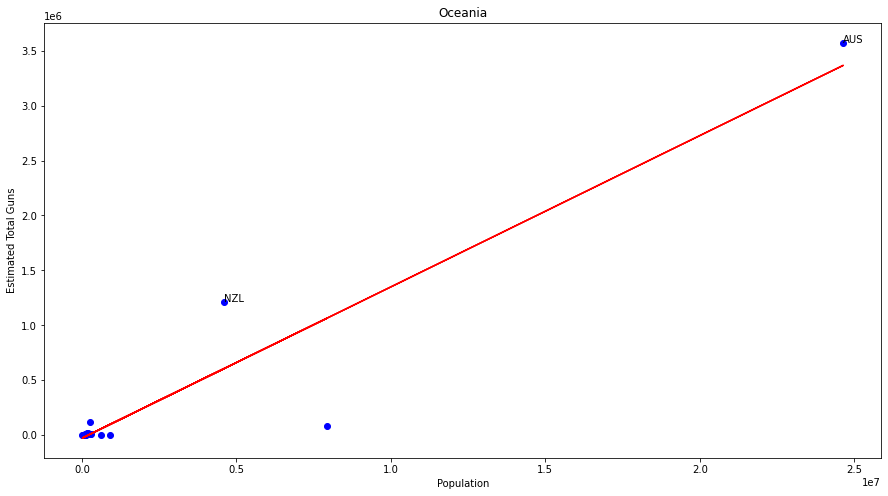

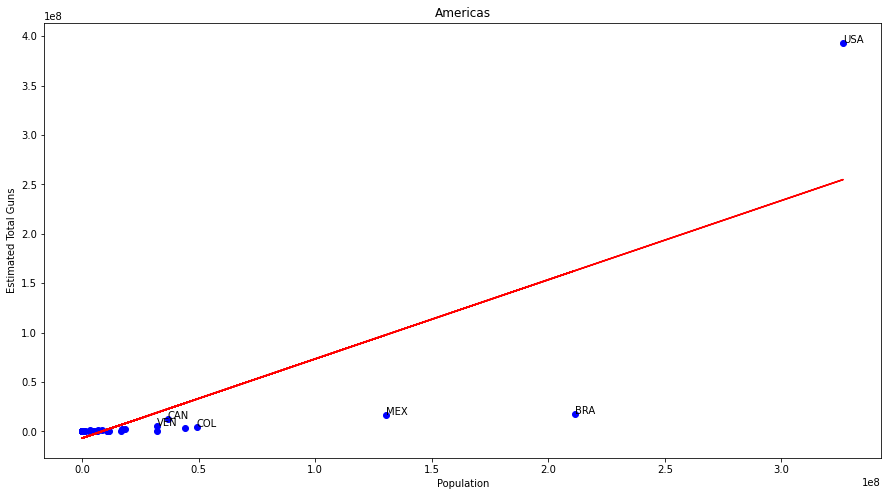

In [18]:
# Pretty much the same process, but with some extra steps
titles = list(guns_per_region.keys())
# Here we have implemented thresholds for the minimum value for gun ownership that we want to label on the graphs
thresholds = {'Asia': 40000000, 'Europe': 10000000, 'Africa': 3000000, 'Oceania': 1000000, 'Americas': 4500000}
for i in titles:
    x = (np.array(list(pop[i].values())))
    y = (np.array(list(guns[i].values())))

    plt.figure(figsize=(15, 8))
    plt.scatter(x, y, color="Blue")

    # Fit a regression to check for linearity
    regr = LinearRegression()

    regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    plt.plot(x.reshape(-1, 1), regr.predict(x.reshape(-1, 1)), color="Red")

    plt.xlabel("Population")
    plt.ylabel("Estimated Total Guns")
    plt.title(i)

    # Label the highest-ranking nations on the graphs with their country code
    for j in pop[i].keys():
        # Check if it meets the threshold, and if so, label the point with its country code
        if guns[i][j] >= thresholds[i]:
            plt.text(x=pop[i][j], y=guns[i][j], s=j)
    plt.show()

These graphs would all suggest that there is a pretty significant correlation between a nation's population and its total number of guns. However, for some nations, this is a given, since some nations have WAY more people than others. It is probably more useful to look at a measure of guns per people rather than total guns for the whole nation. Let's plot our information again, and this time see if there is a correlation between the number of guns per 100,000 people in a country and that country's population. This can be done in the same way as before, but using different data for the axes:

In [20]:
pop = {}
guns_per = {}
for key in guns_per_region.keys():
    table = guns_per_region[key]
    total_pop = {}
    total_gun = {}
    for row in table.iterrows():
        total_pop[row[1]['country_code']] = int(row[1]['population'].replace(",", ""))
        total_gun[row[1]['country_code']] = row[1]['guns_per_100k']
    pop[key] = total_pop
    guns_per[key] = total_gun

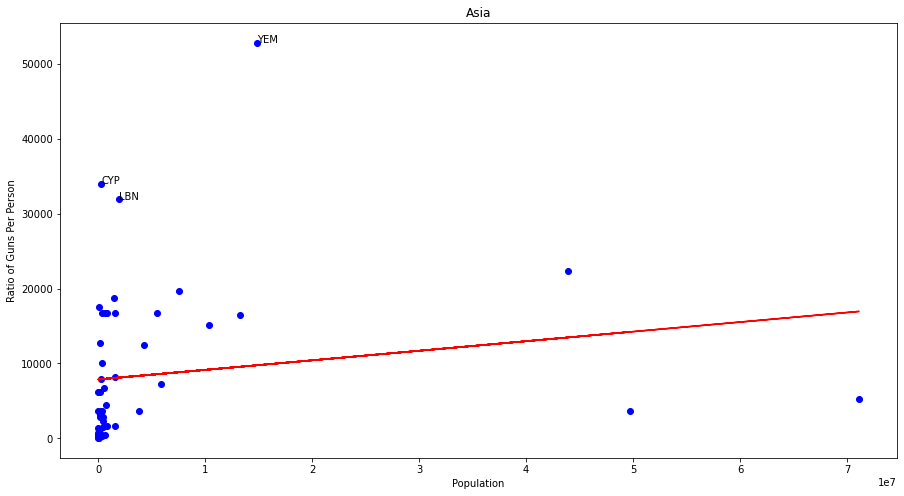

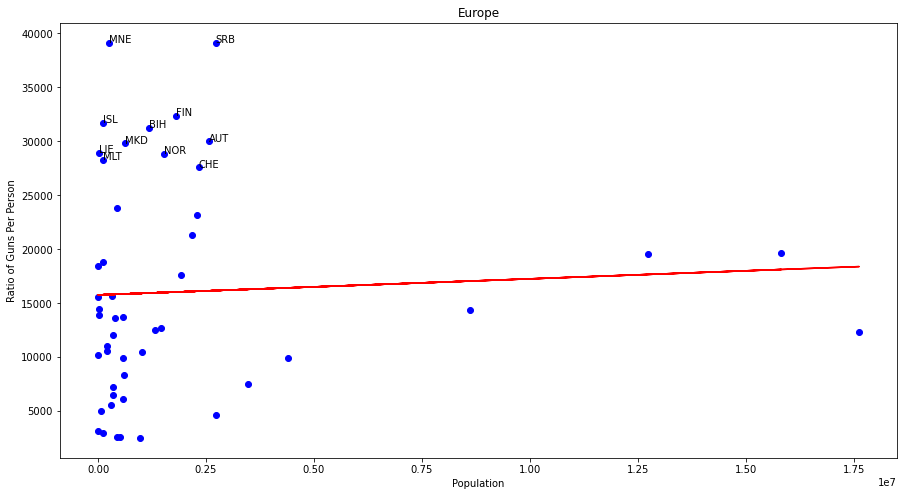

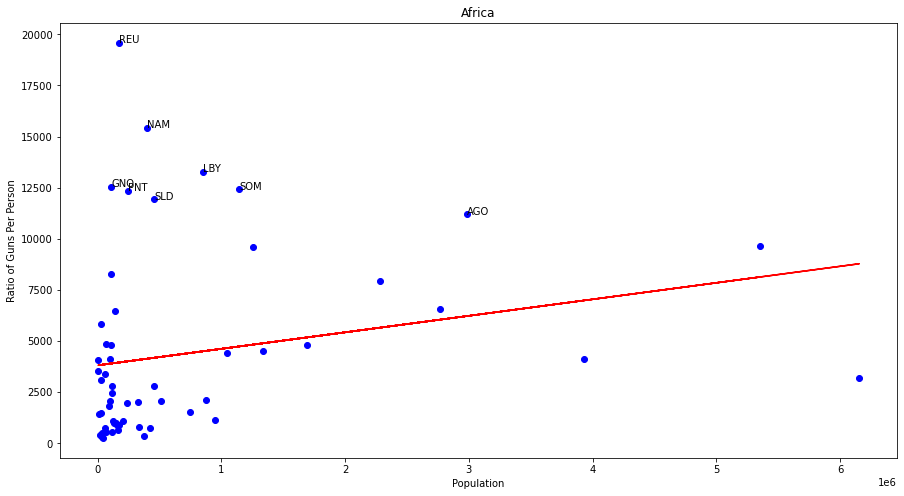

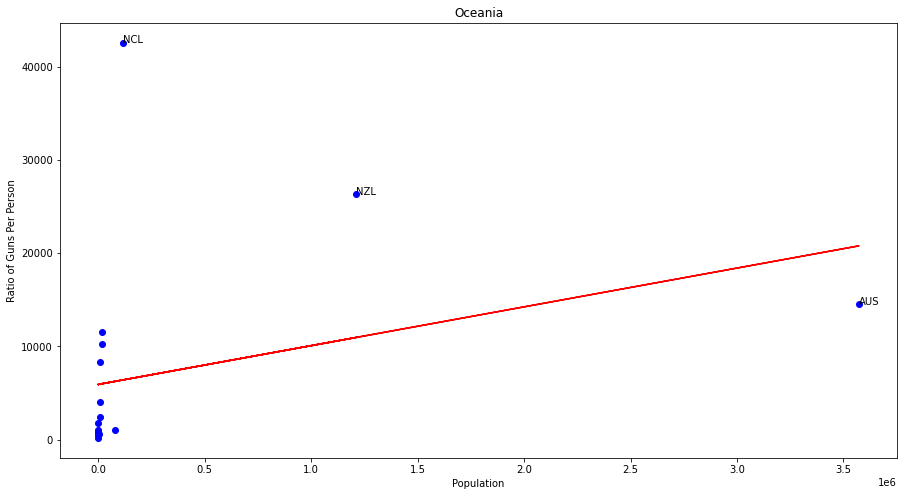

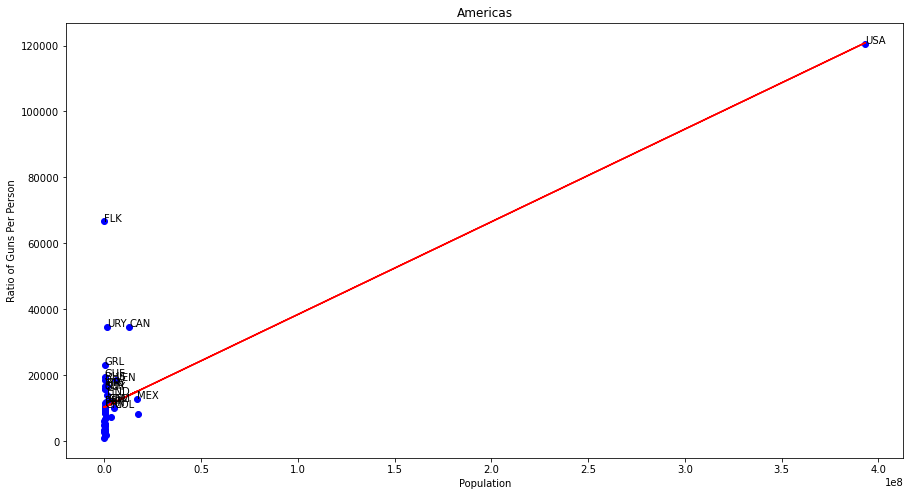

In [22]:
titles = list(guns_per_region.keys())
# Again, set our thresholds to only see labels for the most significant data
thresholds = {'Asia': 30000, 'Europe': 25000, 'Africa': 11000, 'Oceania': 14000, 'Americas': 10000}
# Here I will set up this dictionary to gather all of the significant data to compare homicide rates with afterwards
check_guns_per = {}
for i in titles:
    x = (np.array(list(guns[i].values())))
    y = (np.array(list(guns_per[i].values())))

    plt.figure(figsize=(15, 8))
    plt.scatter(x, y, color="Blue")
    
    # Fit a new linear regression
    regr = LinearRegression()

    regr.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    plt.plot(x.reshape(-1, 1), regr.predict(x.reshape(-1, 1)), color="Red")

    plt.xlabel("Population")
    plt.ylabel("Ratio of Guns Per Person")
    plt.title(i)

    for j in guns[i].keys():
        # Check if it meets the threshold, and if so, label the point with its country code, and store it in check_guns_per
        if guns_per[i][j] >= thresholds[i]:
            if not check_guns_per.get(i, False):
                check_guns_per[i] = []
            check_guns_per[i].append(j)
            plt.text(x=guns[i][j], y=guns_per[i][j], s=j)
    plt.show()

Here, the data becomes interesting. Clearly there is not a significant positive linear relationship between these two factors -- in fact, some even have a negative linear relationship. From this information, we can conclude that population, on its own, is not responsible for influencing the measure of guns per person in a given country. From these graphs, we can see some nations, like the Falkland Islands in the Americas, Yemen in Asia, and New Caledonia in Oceania, have very high proportions of guns per person while having very small populations, whereas with the United States we get the only instance suggestive of a positive linear relationship (almost 1-to-1). I guess this goes to show just how many guns are here. However, this does not necessarily mean that the United States is the most dangerous country. Using the countries we have gathered, we can compare these nations' ratios of guns per person with the ratio of homicides per person. This way, we can see if there is a positive correlation between the proportion of guns per person in a country with the proportion of homicides per person in a country, and determine whether or not access to guns is the primary contributing factor to what makes countries dangerous.

In [24]:
# Here we have two dictionaries, one maps country codes to ratios of guns per person and the other maps country codes to ratios of homicides per person

guns_per = {}
hom_rates = {}
# We can iterate through the list of country codes we collected in the step before
for key in check_guns_per.keys():
    to_use = check_guns_per[key]
    for country in to_use:
        ser = gun_owners.loc[gun_owners['country_code'] == country]
        if country == 'USA':
            name = 'United States'
        else:
            name = ser['country'][ser.index[0]]
        # Match the country code from the gun ownership table with the country in the homicide table
        if len(homs.loc[homs['Country'] == name].index) > 0:
            guns_per[country] = ser['guns_per_100k'][ser.index[0]]
            ser2 = homs.loc[homs['Country'] == name]
            hom_rates[country] = ser2['Value'][ser2.index[0]]

Now we have gathered our data for gun ownership rates and homicide rates per person in each of the countries that we set out to analyze, and can put them into a graph for analysis:

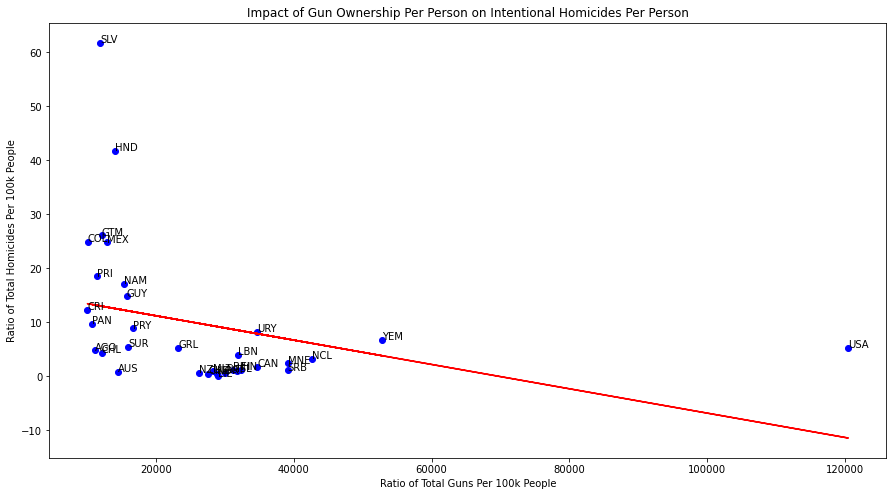

In [26]:
g = (np.array(list(guns_per.values())))
h = (np.array(list(hom_rates.values())))

plt.figure(figsize=(15, 8))
plt.scatter(g, h, color="Blue")
    
# Check for a linear relationship
regr = LinearRegression()

regr.fit(g.reshape(-1, 1), h.reshape(-1, 1))
plt.plot(g.reshape(-1, 1), regr.predict(g.reshape(-1, 1)), color="Red")

plt.xlabel("Ratio of Total Guns Per 100k People")
plt.ylabel("Ratio of Total Homicides Per 100k People")
plt.title("Impact of Gun Ownership Per Person on Intentional Homicides Per Person")

# Label the text on the table
for j in guns_per.keys():
    plt.text(x=guns_per[j], y=hom_rates[j], s=j)
plt.show()

# FINAL THOUGHTS

Now this graph is an interesting one indeed. To state the obvious, there is definitely NOT a positive linear relationship between guns per person and intentional homicides per person. In fact, many of the nations that were marked as being above the stated threshold for their region are all around the same area on the table, whereas nations like the United States are shown to have MANY guns with relatively LOW homicides, and nations like El Salvador and Honduras are shown to have MANY homicides with LOW ratios of guns per person. Of the many conclusions that can be drawn from this diagram, we can conclude that there are other factors that are more significant when considering the causes of violence within countries than the proportions of the amount of guns per person. We can observe that having more guns per person does not inherently mean that the nation is more violent, and that a nation having high levels of homicides per person does not inherently mean that the nation has a lot of guns per person. There are other factors to consider that are more influential on the homicide rate than the amount of guns. We can also note that, as far as the United States is concerned, while we definitely have our problems, it could be much worse.